In [1]:
import os,sys
import csv
import copy
import math
import collections

import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans

from models.shallow_water_solver import shallow_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use(['dark_background'])

In [2]:

#filepath = '/home/pgrover/working/working/Paper_4_Turbulence_Modelling/FlumeExperiment/geometries/flume_profile_smoothed.txt'
filepath = 'flume_profile_smoothed_v002.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
retval = collections.OrderedDict()


z = []
with open(filepath) as f:
    for line in f:
        values = line.split()
        if is_number(values[0])==False:
            if float(values[1]).is_integer():
                retval[values[0]]=int(values[1])
            else:
                retval[values[0]]=float(values[1])
        else:
            z.append(float(values[0]))
z = np.array(z)
print('Z: {0}'.format(len(z)))
xmax = float(retval['nrows']) * retval['cellsize']
nx = retval['nrows']
dx = retval['cellsize']

#--------------------------------
# Increase the resolution on the grid
#--------------------------------
resolution = 2
x = np.linspace(0, nx*dx, num=len(z))
f = interp1d(x, z)
xnew = np.linspace(0, nx*dx, num=len(z)*resolution)
znew = f(xnew)
nx = len(xnew)

print('Finished reinterpolating the grid nx={0}'.format(len(xnew)))


Z: 87
Finished reinterpolating the grid nx=174


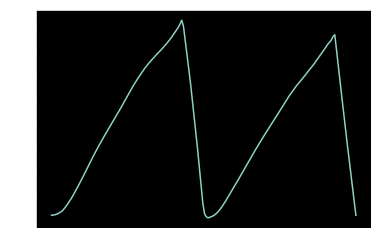

In [3]:
plt.plot(xnew,znew)

In [13]:
#--------------------------------
# Set up the constants
#--------------------------------
a=0.001
b=3.0
Q=10.0
nP=0.4
Slope = 1.0/792.0
mannings = 0.022
s= 0.2      # Surface water elevation
beta = 0.01

# Sediment properties
D50 = 0.001     # Particle Diameter
rho_particule = 2650

#--------------------------------
# Set up the domain, BCs and ICs
#--------------------------------
import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

x = pyclaw.Dimension(0.0,xmax,len(xnew),name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

zc = znew.copy()
z_hydro = znew.copy()

 # Gravitational constant
state.problem_data['grav'] = 9.8
state.problem_data['sea_level'] = 0.0


# Set up the inital state of the flow
shw_slvr = shallow_solver(domain, slope=Slope, mannings=mannings)
u, surf,h = shw_slvr.run(zc,s)


if np.isnan(u).any():
    # Get the flow
    print( u)
    raise ValueError('Failed to calculate the flow')



Grid dx = 0.015
Grid nx = 174


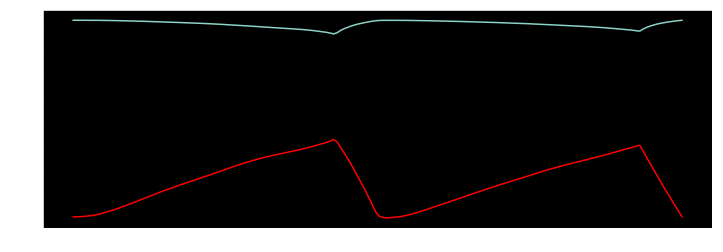

In [14]:
fig = plt.figure(figsize=(12, 4))
plt.plot(xc,surf)
plt.plot(xc,zc,'r')

Text(0, 0.5, '$u$ (m/s)')

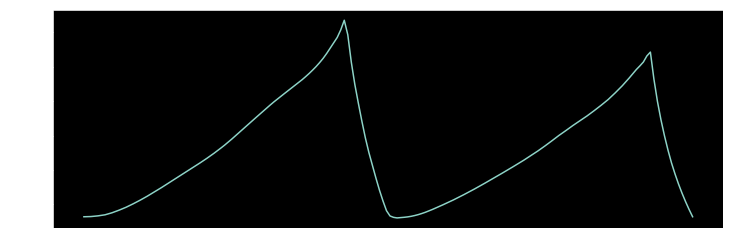

In [19]:
fig = plt.figure(figsize=(12, 4))
plt.plot(xc,u)
plt.ylabel('$u$ (m/s)')

In [20]:
u.mean()

0.4299808693200725

In [12]:

#--------------------------------
# Initialize the sed transport 
#--------------------------------    
# Eq 57
qbedload = np.zeros(nx)
roe_speed = np.zeros(nx)
qbedload = a*u**b
flux = np.zeros(nx)

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 600. # Runtime in seconds
dt = 1 # Time step size (s)
nt = int(simTime/dt)  # Number of time steps


#--------------------------------
# Set up the model reporting parameters
#--------------------------------
z0 = zc.copy() 
z600 = zc.copy() 
z2000 = zc.copy()
verts = []
extractionInterval = 5.
tsteps=[]
iterations = 0
cntr=0
#--------------------------------
#  Run the model
#--------------------------------
for n in range(1,nt):  
    zn = zc.copy() 
    for i in range(0,nx): #i=2
        zloc = get_stencil(zn,i-2,i+4)        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc)!=6:
            raise ValueError('Stencil is incorrect')
 
        # Determine the Upwind flux
        # The 0.5 comes from the c+abs(c) which is 2 if the wave speed is +ive
        # this is the evaluation of the left and right based fluxes. Eq. 18 and 19        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed[i]=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed[i] >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out
    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        zc[i] = zn[i]-(1./(1.-nP))*dt/dx*(floc[1]-floc[0])
    
    bed_max_delta = np.max(np.abs(zn - zc))
    
    # Apply the avalanche model
    zc, iterations1 = avalanche_model(dx,xc, zc, adjustment_angle=28.)
    # Now flip it to run in reverse
    zflip = np.flip(zc, axis=0)
    zflip, iterations1 = avalanche_model(dx,xc, zflip, adjustment_angle=28.)
    zc = np.flip(zflip, axis=0)
    
    #zc = z_updated.copy()
    
    # Re-run the solver and updated the sediment transport
    # Check if the avalanche model was updated OR the bed changed greater than the threshold
    #if iterations > 10 or bed_max_delta > 0.00005:
    iterations+=1
    if iterations > 2:
        u, surf,h = shw_slvr.run(zc,s)
        iterations = 0
        #print('Updated')
        # Remove the old method 
        #qbedload = a*u**b
    slope = np.gradient(zc,dx)
    
    ## Nov 13 2018 - Can modify later
    for i in range(0,nx): #i=2        
        #zlocal = get_stencil(zc,i-2,i+2)
        #qbedload[i] = sedtrans.get_unit_bed_load2(h[i],u[i],D50,rho_particule,type='bagnold')
        qbedload[i] = sedtrans.get_unit_bed_load_slope(h[i],u[i],D50,slope[i], rho_particule, angleReposeDegrees = 30.0, type='mpm')
        #qbedload[i] = sedtrans.get_unit_bed_load2(h[i],u[i],D50,rho_particule, type='mpm')
    
    if (n*dt / extractionInterval) == math.floor(n*dt / extractionInterval):
        verts.append(list(zip(xc.copy(),zc.copy())))
        tsteps.append(n*dt)        
        np.save('flume_dunes', verts)
    
    cntr += 1
    if cntr == extractionInterval:
        cntr = 0
        print('Time step {0} of {1} - bed_max_delta {2}'.format(n,nt,bed_max_delta))    
        
print('Done')

Time step 5 of 600 - bed_max_delta 0.0004205661350909773
Time step 10 of 600 - bed_max_delta 0.00024099449699659103
Time step 15 of 600 - bed_max_delta 0.00016567972484569926
Time step 20 of 600 - bed_max_delta 0.00012285260356589833
Time step 25 of 600 - bed_max_delta 0.00010049604838862497
Time step 30 of 600 - bed_max_delta 9.323351268915314e-05
Time step 35 of 600 - bed_max_delta 8.912817042169147e-05
Time step 40 of 600 - bed_max_delta 8.772251665598724e-05
Time step 45 of 600 - bed_max_delta 8.518184927740202e-05
Time step 50 of 600 - bed_max_delta 8.48564794217535e-05
Time step 55 of 600 - bed_max_delta 8.453641431741682e-05
Time step 60 of 600 - bed_max_delta 8.338655040575002e-05
Time step 65 of 600 - bed_max_delta 8.253577451825672e-05
Time step 70 of 600 - bed_max_delta 8.161236285113976e-05
Time step 75 of 600 - bed_max_delta 8.070652521692534e-05
Time step 80 of 600 - bed_max_delta 8.023418151369491e-05
Time step 85 of 600 - bed_max_delta 7.965189435907641e-05
Time step 90

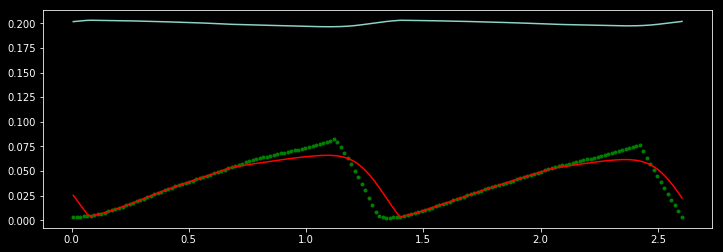

In [13]:
fig = plt.figure(figsize=(12, 4))
plt.plot(xc,surf)
plt.plot(xc,znew,'g.')
plt.plot(xc,zc,'r')

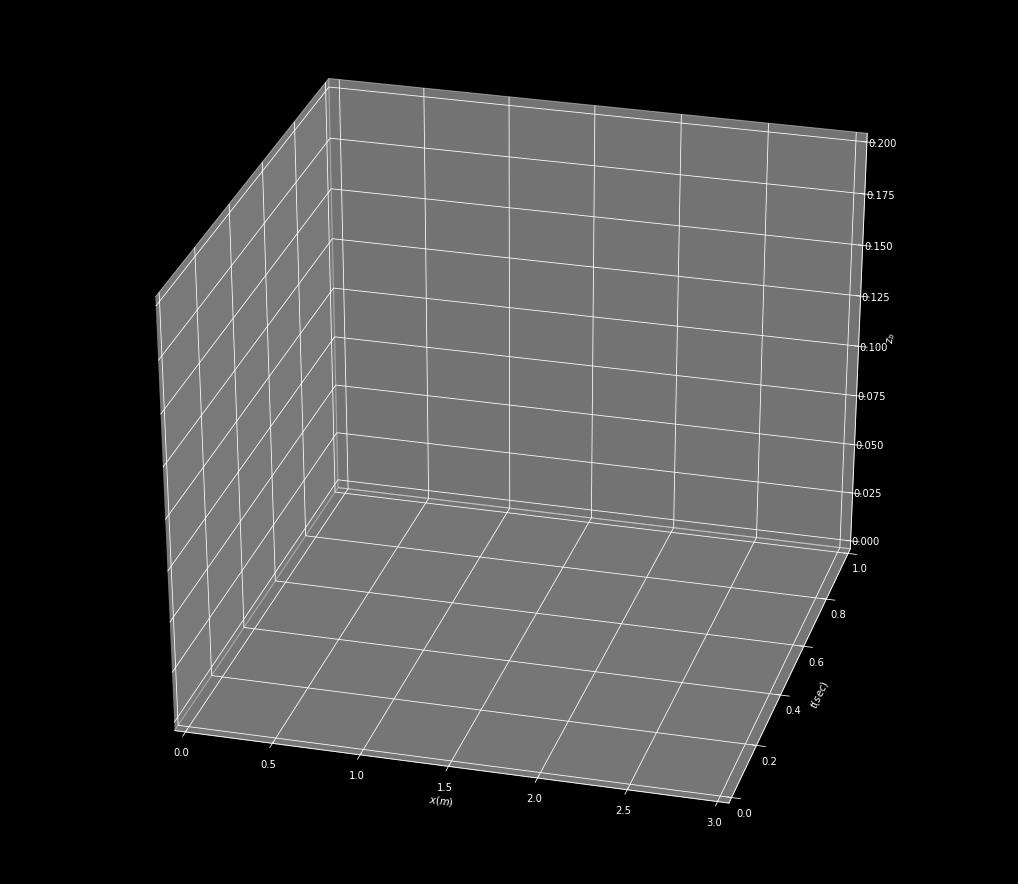

In [14]:
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

lines = LineCollection(verts)

fig = plt.figure(figsize=(18, 16))
ax = fig.gca(projection='3d')
lines.set_alpha(0.7)
ax.add_collection3d(lines, zs=tsteps, zdir='y')
ax.set_xlim3d(0, 3)
ax.set_zlim3d(0, 0.2)
#ax.set_ylim3d(0, 3600)
ax.set_zlabel('$z_b$')
ax.set_ylabel('$t(sec)$')
ax.set_xlabel('$x(m)$')

#view_init(elev=None, azim=None)
ax.view_init(30, -75)